# Лабораторная работа №3: Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

**Цель лабораторной работы:** изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## Загрузка и первичный анализ данных

Для данной работы используем набор данных о персональных симптомах сердечно сосудистых заболеваний людей: 
https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [2]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


В имеющихся данных 12 колонок и 918 строк. Пропуски в данных отсутствуют. Согласно полученной документации:

* `Age`: возраст пациента в годах
* `Sex`: пол пациента (М: Мужской, F: Женский)
* `ChestPainType`: Типы боли в груди (TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомная)
* `RestingBP`: артериальное давление в состоянии покоя (mm Hg)
* `Cholesterol`: сывороточный холестерин (mm/dl)
* `FastingBS`: уровень сахара в крови натощак (1: если FastingBS > 120 mg/dl, 0: в других случаях)
* `RestingECG`: результаты электрокардиограммы в покое (Normal: Нормальные, ST: аномалия ST-T, LVH: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса)
* `MaxHR`: максимальная частота сердечных сокращений
* `ExerciseAngina`: стенокардия, вызванная физической нагрузкой (Y: Да, N: Нет)
* `Oldpeak`: oldpeak = ST (Числовое значение, измеренное в депрессии)
* `ST_Slope`: наклон пикового сегмента ST в упражнении (Up: восходящий, Flat: горизонтальный, Down: нисходящий)
* `HeartDisease`: выходной класс (1: присутствует заболевание сердца, 0: норма)

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Переименуем колонки для большей наглядности и удобства в работе:

In [5]:
data = data.rename(columns={'Age':'age',
                            'Sex':'sex',
                            'ChestPainType':'chest_pain_type',
                            'RestingBP' : 'resting_BP',
                            'Cholesterol' : 'cholesterol',
                           'FastingBS' : 'fasting_BS',
                           'RestingECG' : 'resting_ECG',
                           'MaxHR' : 'max_HR',
                           'ExerciseAngina' : 'is_exercise_angina',
                           'Oldpeak' : 'oldpeak',
                           'ST_Slope' : 'ST_slope',
                           'HeartDisease' : 'is_heart_disease'})

In [6]:
data.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_BP', 'cholesterol',
       'fasting_BS', 'resting_ECG', 'max_HR', 'is_exercise_angina', 'oldpeak',
       'ST_slope', 'is_heart_disease'],
      dtype='object')

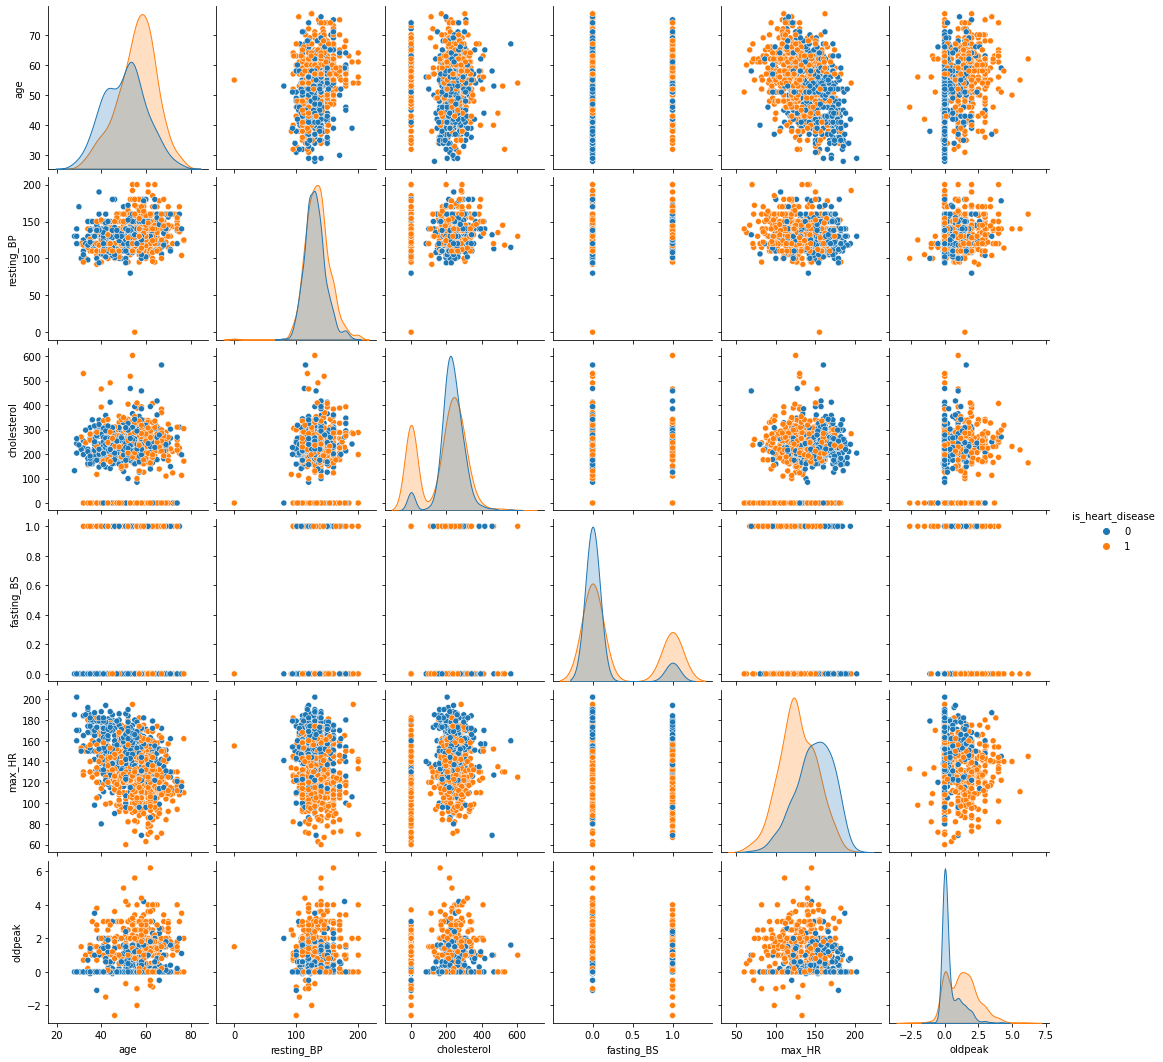

In [7]:
sns.pairplot(data, hue='is_heart_disease')

## Кодирование категориальных признаков числовыми значениями

Проведем кодирование категориальных признаков, для применения их в обучении модели:

In [10]:
data_ohe = pd.get_dummies(data, columns=['sex', 'chest_pain_type', 'resting_ECG', 'is_exercise_angina', 'ST_slope'], drop_first=1)

In [11]:
data_ohe

,age,resting_BP,cholesterol,fasting_BS,max_HR,oldpeak,is_heart_disease,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ECG_Normal,resting_ECG_ST,is_exercise_angina_Y,ST_slope_Flat,ST_slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


Кодирование категориальных признаков завершено, перейдем к следующему пункту

## Масштабирование данных

Проведем масштабирование данных, используя MinMax стратегию:

In [12]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['age', 'resting_BP', 'cholesterol', 'max_HR', 'oldpeak']])
sc1_data

array([[0.24489796, 0.7       , 0.47927032, 0.78873239, 0.29545455],
       [0.42857143, 0.8       , 0.29850746, 0.67605634, 0.40909091],
       [0.18367347, 0.65      , 0.46932007, 0.26760563, 0.29545455],
       ...,
       [0.59183673, 0.65      , 0.2172471 , 0.38732394, 0.43181818],
       [0.59183673, 0.65      , 0.39137645, 0.8028169 , 0.29545455],
       [0.20408163, 0.69      , 0.29021559, 0.79577465, 0.29545455]])

In [13]:
sc1_data.shape

(918, 5)

Перенесем отмасштабированные значения в датафрейм:

In [14]:
for i in range(0, 5):
    if i == 0:
        data_ohe['age'] = pd.Series(sc1_data[:, i].tolist())
    elif i == 1:
        data_ohe['resting_BP'] = pd.Series(sc1_data[:, i].tolist())
    elif i == 2:
        data_ohe['cholesterol'] = pd.Series(sc1_data[:, i].tolist())
    elif i == 3:
        data_ohe['max_HR'] = pd.Series(sc1_data[:, i].tolist())
    elif i == 4:
        data_ohe['oldpeak'] = pd.Series(sc1_data[:, i].tolist())

In [15]:
data_ohe.head()

,age,resting_BP,cholesterol,fasting_BS,max_HR,oldpeak,is_heart_disease,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ECG_Normal,resting_ECG_ST,is_exercise_angina_Y,ST_slope_Flat,ST_slope_Up
0,0.244898,0.70,0.479270,0,0.788732,0.295455,0,1,1,0,0,1,0,0,0,1
1,0.428571,0.80,0.298507,0,0.676056,0.409091,1,0,0,1,0,1,0,0,1,0
2,0.183673,0.65,0.469320,0,0.267606,0.295455,0,1,1,0,0,0,1,0,0,1
3,0.408163,0.69,0.354892,0,0.338028,0.465909,1,0,0,0,0,1,0,1,1,0
4,0.530612,0.75,0.323383,0,0.436620,0.295455,0,1,0,1,0,1,0,0,0,1


## Разделение выборки данных на обучающую и тестовую

In [16]:
KNeighborsClassifierObj = KNeighborsClassifier(n_neighbors=5)

In [17]:
target=data_ohe['is_heart_disease']
features = data_ohe.drop('is_heart_disease', axis=1)

In [18]:
target.shape

(918,)

In [19]:
features.shape

(918, 15)

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=1)

Оценим размеры выборок:

In [21]:
features_train.shape

(734, 15)

In [22]:
features_test.shape

(184, 15)

In [23]:
target_train.shape

(734,)

In [24]:
target_test.shape

(184,)

## Построение модели на основе метода ближайших соседей

In [25]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(features_train, target_train)
predictions_test_2 = model.predict(features_test)

In [26]:
print(predictions_test_2.shape[0], target_test.shape[0])

184 184


In [27]:
model2 = KNeighborsClassifier(n_neighbors=10)
model2.fit(features_train, target_train)
predictions_test_10 = model2.predict(features_test)

In [28]:
print(predictions_test_10.shape[0], target_test.shape[0])

184 184


## Оценка качества модели

### Исходная модель

Оценим качество модели встроенной метрикой оценки библиотки sklearn для 2ух ближайших соседей:

In [30]:
print(precision_score(target_test, predictions_test_2))

0.945054945054945


In [31]:
print(recall_score(target_test, predictions_test_2))

0.7818181818181819


In [32]:
print(f1_score(target_test, predictions_test_2))

0.8557213930348259


In [33]:
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

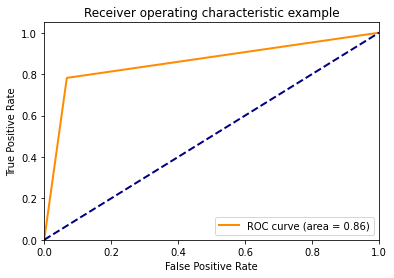

In [34]:
# Для 2 ближайших соседей
draw_roc_curve(target_test, predictions_test_2, pos_label=1, average='micro')

Таким же методом оценим качество модели для 10 ближайших соседей:

In [35]:
print(precision_score(target_test, predictions_test_10))

0.9017857142857143


In [36]:
print(recall_score(target_test, predictions_test_10))

0.9181818181818182


In [37]:
print(f1_score(target_test, predictions_test_10))

0.9099099099099099


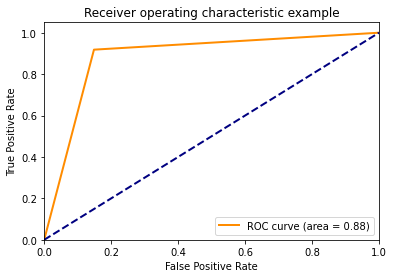

In [38]:
draw_roc_curve(target_test, predictions_test_10, pos_label=1, average='micro')

### Кросс-валидация

In [39]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=10), features, target, cv=5, scoring="f1")

In [40]:
scores

array([0.92156863, 0.82978723, 0.87610619, 0.81904762, 0.75897436])

### Подбор гиперпараметров

In [41]:
n_range = np.array(range(5, 55, 5))
tuned_parametrs = [{'n_neighbors' : n_range}]
tuned_parametrs

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [42]:
%%time

tuned_GS = GridSearchCV(KNeighborsClassifier(), tuned_parametrs, cv=5, scoring='f1')
tuned_GS.fit(features, target)

Wall time: 678 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='f1')

In [43]:
tuned_GS.best_params_

{'n_neighbors': 30}

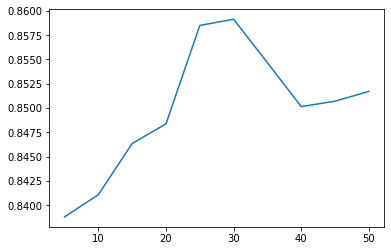

In [44]:
plt.plot(n_range, tuned_GS.cv_results_['mean_test_score'])

In [45]:
tuned_GS.best_estimator_.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=30)

In [46]:
predictions_tuned_train = tuned_GS.best_estimator_.predict(features_train)
predictions_tuned_test = tuned_GS.best_estimator_.predict(features_test)

In [47]:
print(f1_score(target_train, predictions_tuned_train))

0.8585485854858549


In [48]:
print(f1_score(target_test, predictions_tuned_test))

0.9369369369369368


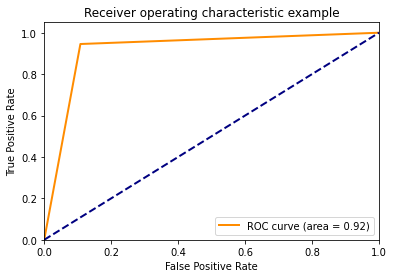

In [49]:
draw_roc_curve(target_test, predictions_tuned_test, pos_label=1, average='micro')

In [50]:
print(precision_score(target_test, predictions_tuned_test))

0.9285714285714286


In [51]:
print(recall_score(target_test, predictions_tuned_test))

0.9454545454545454


In [52]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [53]:
X, y = features, target

title = "Learning Curves (KNeighbors)"

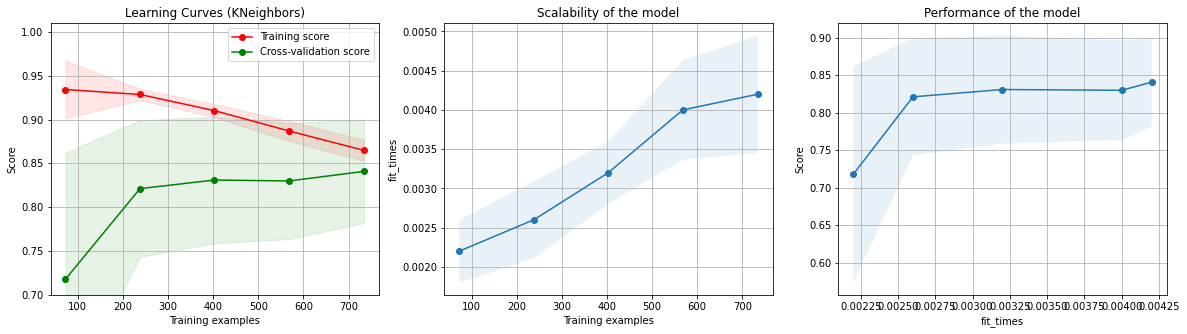

In [54]:
plot_learning_curve(
    tuned_GS.best_estimator_, title, X, y, ylim=(0.7, 1.01), cv=5, n_jobs=4
)
plt.show()

In [55]:
X, y = features, target
subset_mask = np.isin(y, [0, 1])  # binary classification: 0 vs 1
X, y = X[subset_mask], y[subset_mask]
X.shape, y.shape

((918, 15), (918,))

In [56]:
def plot_validation_curve(estimator, X, y, 
                         param_name, param_range, cv,
                         scoring='f1'):
    train_scores, test_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        n_jobs=1,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title("Validation Curve with KNeighbors")
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range,
        train_scores_mean,
        label="Training score",
        color='darkorange',
        lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.4,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range,
        test_scores_mean,
        label="Cross-validation score",
        color="navy",
        lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

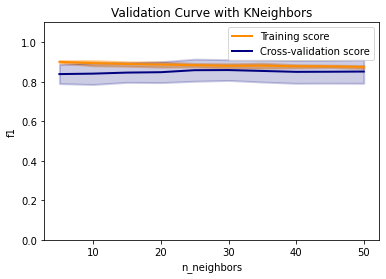

In [57]:
plot_validation_curve(tuned_GS.best_estimator_, X=features, y=target, param_name='n_neighbors', param_range=n_range, cv=20, scoring="f1")